# Plot

In [1]:

#from torch.utils.data import Dataset
import matplotlib.pyplot as plt 

## Plot Legend Bar

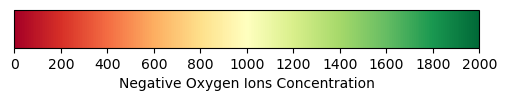

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an axis (which won't actually be used for plotting)
fig, ax = plt.subplots(figsize=(6, 1))  # Adjust the figure size as needed
fig.subplots_adjust(bottom=0.5)  # Adjust the placement of the subplot to make room for the colorbar

# Generate a colormap; no need to plot, but necessary for colorbar creation
cmap = plt.cm.RdYlGn
norm = plt.Normalize(vmin=0, vmax=2000)

# Create a dummy scalar mappable based on the colormap and norm
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can set this to an empty list as the actual values are not important

# Display the colorbar based on the scalar mappable
cb = plt.colorbar(sm, cax=ax, orientation='horizontal', ticks=np.arange(0, 2200, 200))

# Set the colorbar label
cb.set_label('Negative Oxygen Ions Concentration')

plt.show()


## 1. Plot Image with Given Date

Given:
- Xarray
- feature to plot
- date
- mask (shp)

Wanted:
- Figure

In [1]:
grib_predict_path=r"C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2022_Jan_2_Mar_predicted.nc"
date='2022-02-25T12:00:00.000000000'

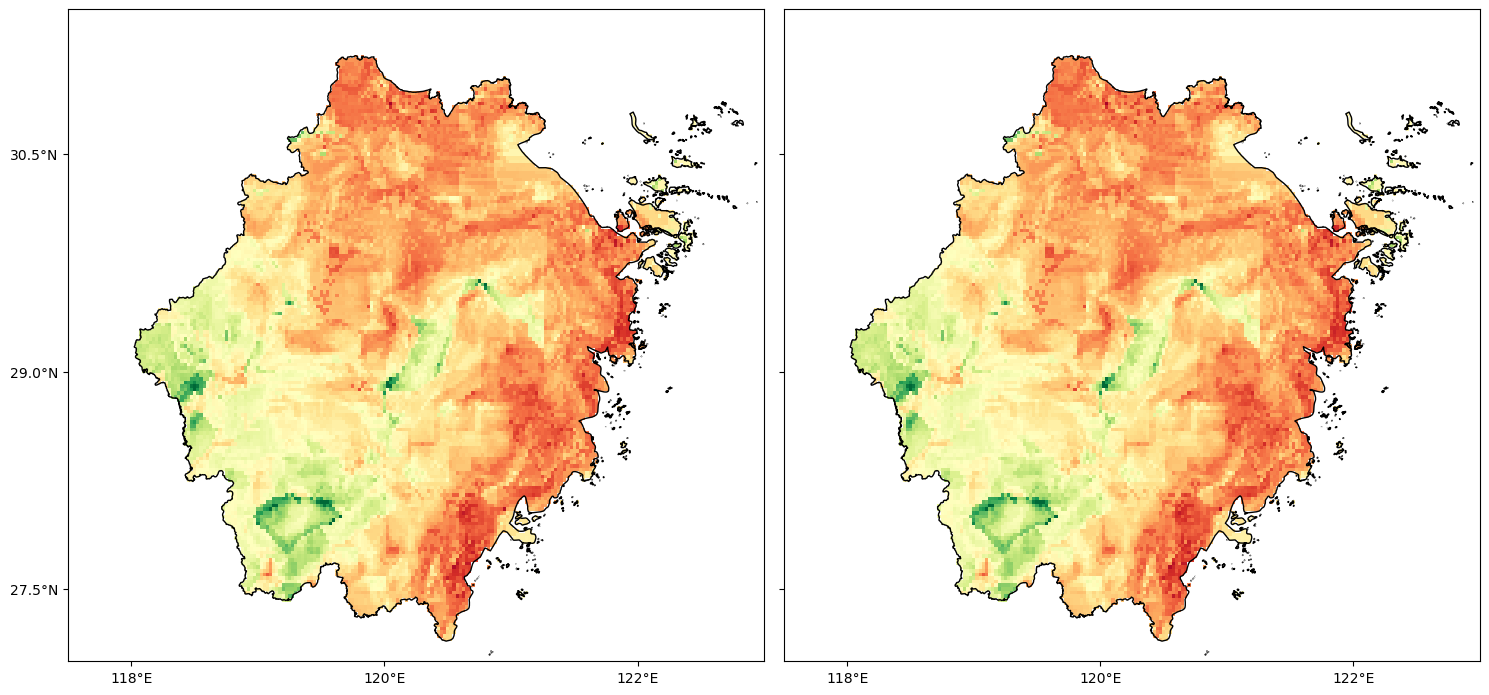

In [4]:
import sys 
import geopandas as gpd
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.prediction import make_mask, plot_single_ds
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

x_predicted = xr.open_dataset(grib_predict_path)['Negative_oxygen_ions']
zhejiang=gpd.read_file(r'C:\Datasets\Zhejiang20-23RS\Earth\Xian_dissolved.shp').to_crs('EPSG:4326')
mask = make_mask(x_predicted, zhejiang)

# Mask the DataArray with the rasterized GeoDataFrame
ds_masked = x_predicted.where(mask)
ds_masked = ds_masked.sel(time=date)

# Prepare a 3x3 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)

for ax in axes.flatten():
    # Duplicate the plotting of ds_masked and Zhejiang boundary
    plot_single_ds(ax, ds_masked, color_range=[-1,1])
    zhejiang.plot(ax=ax, color="none", edgecolor="black")
    
    ax.set_xlim([117.5, 123])
    ax.set_ylim([27, 31.5])
    xxrange=np.arange(118, 123, 2)
    yyrange=np.arange(27.5, 31.5, 1.5)
    ax.set_xticks(xxrange)
    ax.set_yticks(yyrange)
    ax.set_xticklabels([f"{x}°E" for x in xxrange])
    ax.set_yticklabels([f"{y}°N" for y in yyrange])
    ax.axis('on')

plt.tight_layout()
plt.show()


## Ploy Image with Given Date Aggregation

Given:
- Xarray:  'Datetime' 'NLatitude', 'ELongtitude'
- Feature: To be plot
- Y, M, Day, H: Wanted aggregated day of month.

Wanted:
- plot of possible combination

In [5]:
grib_predict_path=r"C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2022_Jan_2_Mar_predicted.nc"
 
Year=None
Mon=None
Day=None # [1, 5, 10, 15, 20, 25]
Hour=[0, 4, 8, 12, 16, 20]
figsize=(15,15)
ax_per_row=3



6it [00:01,  3.06it/s]


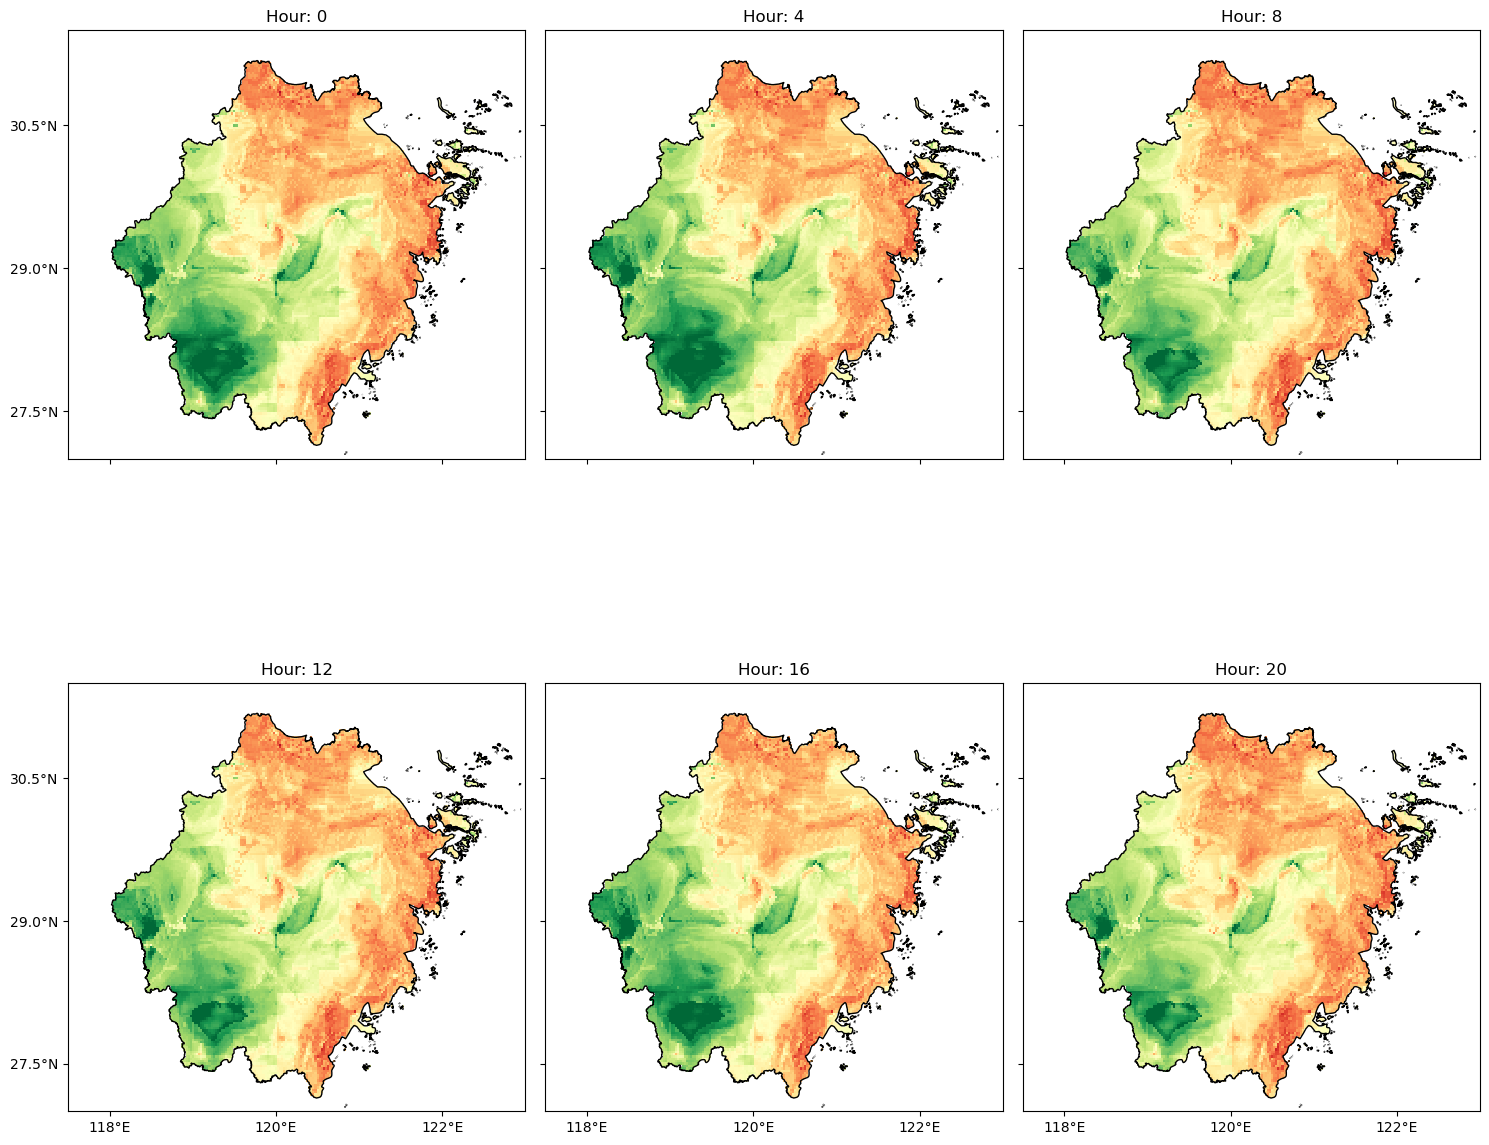

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from typing import List, Optional
from tqdm import tqdm

def plot_aggregations(ds: xr.Dataset, shp, variable: str, Year: Optional[List[int]] = None, Mon: Optional[List[int]] = None,
                      Day: Optional[List[int]] = None, Hour: Optional[List[int]] = None, figsize: tuple = (15, 5),
                      ax_per_row: int = 3, time: str="time"):
    """
    Aggregates and plots the dataset for specific combinations of Year, Month, Day, and Hour using datetime accessors.

    Args:
        ds (xr.Dataset): The input xarray dataset.
        variable (str): The variable name to aggregate and plot.
        Year (Optional[List[int]]): List of years or None.
        Mon (Optional[List[int]]): List of months or None.
        Day (Optional[List[int]]): List of days or None.
        Hour (Optional[List[int]]): List of hours or None.
        figsize (tuple): Figure size for the plots.
        ax_per_row (int): Number of axes per row in the plot grid.
    """
    ds=ds[[variable]]
    mask = make_mask(ds,shp)
    ds = ds.where(mask)
    
    # Prepare the lists for iteration
    years = Year if Year is not None else [None]
    months = Mon if Mon is not None else [None]
    days = Day if Day is not None else [None]
    hours = Hour if Hour is not None else [None]

    # Create all possible combinations
    combinations = list(product(years, months, days, hours))
    
    # Calculate the number of rows needed for subplots
    n_rows = np.ceil(len(combinations) / ax_per_row).astype(int)
    
    fig, axes = plt.subplots(n_rows, ax_per_row, figsize=figsize, squeeze=False, sharex=True, sharey=True)
    axes = axes.flatten()
    
    for idx, (year, mon, day, hr) in tqdm(enumerate(combinations)):
        # Use .dt accessor for dynamic datetime components filtering
        filtered_ds = ds.copy()
        if year is not None:
            filtered_ds = filtered_ds.where(filtered_ds[time].dt.year == year, drop=True)
        if mon is not None:
            filtered_ds = filtered_ds.where(filtered_ds[time].dt.month == mon, drop=True)
        if day is not None:
            filtered_ds = filtered_ds.where(filtered_ds[time].dt.day == day, drop=True)
        if hr is not None:
            filtered_ds = filtered_ds.where(filtered_ds[time].dt.hour == hr, drop=True)
        
        if filtered_ds[variable].size == 0:
            continue  # Skip if the filtered dataset is empty
        
        aggregated_data = filtered_ds[variable].mean(dim=time, skipna=True)
        
        # Plotting
        ax = axes[idx] 
        # Setting the title for each subplot
        title = ""
        title += f"Year: {year}, " if year is not None else ""
        title += f"Month: {mon}, " if mon is not None else ""
        title += f"Day: {day}, " if day is not None else ""
        title += f"Hour: {hr}" if hr is not None else ""
        ax.set_title(title.strip(", "))
 
        # Duplicate the plotting of ds_masked and Zhejiang boundary
        plot_single_ds(ax, aggregated_data ,color_range=[-1,1])
        shp.plot(ax=ax, color="none", edgecolor="black")
        ax.set_xlim([117.5, 123])
        ax.set_ylim([27, 31.5])
        xxrange=np.arange(118, 123, 2)
        yyrange=np.arange(27.5, 31.5, 1.5)
        ax.set_xticks(xxrange)
        ax.set_yticks(yyrange)
        ax.set_xticklabels([f"{x}°E" for x in xxrange])
        ax.set_yticklabels([f"{y}°N" for y in yyrange])
        ax.axis('on')

    plt.tight_layout() 
    plt.show()


import sys
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.prediction import make_mask, plot_single_ds
import geopandas as gpd

 
# Example usage
ds=xr.open_dataset(grib_predict_path)  #x_predicted
shp=gpd.read_file(r'C:\Datasets\Zhejiang20-23RS\Earth\Xian_dissolved.shp').to_crs('EPSG:4326')

# Assuming ds is your loaded xarray dataset and 'tplt' is the variable you want to aggregate and plot
plot_aggregations(ds, shp, 'Negative_oxygen_ions', Year=Year, Mon=Mon, Day=Day, Hour=Hour, figsize=(15,15), ax_per_row=3)


# Plot Time Series 

### Prepare Dataset

Given: 
Wanted: df

In [1]:
# Assuming the initial setup and filtering are the same


site_number = 58656
start_date = '2022-01-01 00:00:00'
end_date = '2022-03-20 00:00:00'
freq='4H'

weight_dir=r'C:\Users\isxzl\OneDrive\Code\AutoGeo\weight'
site_Feature_clean_pkl= r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\site_withCoor_withFea_cleaned.pkl'


In [2]:
import pandas as pd
import numpy as np
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
sys.path.append("C:/Users/isxzl/OneDrive/Code/FeatureInsight")
from sample.dataset import filter_dataframe_by_date
from sample.prediction import load_model 
import pandas as pd
import numpy as np
from feature_engine.imputation import MeanMedianImputer
from FeatureInsight import clean_ds

model,t1,t2,t3,tt1,tt2,tt3,features=load_model(weight_dir)
df = pd.read_pickle(site_Feature_clean_pkl)
df=clean_ds(df)
site_df = df[df['Site_number'] == site_number]

all_dates = pd.date_range(start=start_date, end=end_date, freq=freq)
new_df = pd.DataFrame({'time': all_dates})
merged_df = pd.merge(new_df, site_df, on='time', how='left')
merged_df

C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Items have been loaded successfully.


,time,Site_number,Site_name,Negative_oxygen_ions,longitude,latitude,Air_level,PM25,O3,deg0l,...,swvl2,stl1,swvl3,stl2,lshf,stl3,stl4,lblt,srtm,LC_Type4
0,2022-01-01 00:00:00,58656.0,乐清气象站,130.0,120.96,28.06,一般,58.0,93.0,1858.800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
1,2022-01-01 04:00:00,58656.0,乐清气象站,370.0,120.96,28.06,一般,53.0,46.0,1863.190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
2,2022-01-01 08:00:00,58656.0,乐清气象站,280.0,120.96,28.06,一般,23.0,41.0,2264.695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
3,2022-01-01 12:00:00,58656.0,乐清气象站,220.0,120.96,28.06,一般,27.0,38.0,2413.900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
4,2022-01-01 16:00:00,58656.0,乐清气象站,410.0,120.96,28.06,一般,14.0,59.0,2141.585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,2022-03-19 08:00:00,58656.0,乐清气象站,440.0,120.96,28.06,一般,14.0,50.0,4429.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
467,2022-03-19 12:00:00,58656.0,乐清气象站,600.0,120.96,28.06,清新,23.0,79.0,4389.940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
468,2022-03-19 16:00:00,58656.0,乐清气象站,560.0,120.96,28.06,清新,34.0,58.0,4381.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0
469,2022-03-19 20:00:00,58656.0,乐清气象站,480.0,120.96,28.06,一般,47.0,100.0,4422.495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,6.0


In [6]:
X = df[features] 
X=t1.transform(X)
X=t2.transform(X)
X=t3.transform(X)
df["Negative_oxygen_ions"]=tt1.transform(df[["Negative_oxygen_ions"]])
df["Negative_oxygen_ions"]=tt2.transform(df[["Negative_oxygen_ions"]])

y = model.predict(X)
df["predicted"]=y
df

,Site_number,Site_name,time,Negative_oxygen_ions,longitude,latitude,Air_level,PM25,O3,deg0l,...,stl1,swvl3,stl2,lshf,stl3,stl4,lblt,srtm,LC_Type4,predicted
0,58568,三门气象站,2022-01-01 00:00:00,1010.0,121.38,29.11,清新,72.0,47.0,1617.11250,...,276.367432,0.427250,278.745361,0.650001,283.724121,290.325928,277.455322,232.75,2.0,952.323355
4,58568,三门气象站,2022-01-01 04:00:00,990.0,121.38,29.11,清新,69.0,40.0,1619.91250,...,280.892578,0.427086,279.339844,0.649670,283.675293,290.305176,277.672607,232.75,2.0,993.724942
9,58568,三门气象站,2022-01-01 20:00:00,990.0,121.38,29.11,清新,46.0,29.0,1601.27500,...,276.793213,0.426609,279.860352,0.650001,283.578369,290.225342,277.666992,232.75,2.0,929.804370
13,58568,三门气象站,2022-01-02 00:00:00,1030.0,121.38,29.11,清新,44.0,30.0,1951.82500,...,276.621338,0.426506,279.349121,0.650001,283.542969,290.205811,277.569092,232.75,2.0,919.793371
17,58568,三门气象站,2022-01-02 04:00:00,1040.0,121.38,29.11,清新,51.0,41.0,2483.18750,...,283.763428,0.426189,280.150146,0.650001,283.513916,290.185303,278.136230,232.75,2.0,924.601085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108835,58547,龙游气象站,2022-03-27 04:00:00,920.0,119.18,29.03,清新,16.0,38.0,3020.62750,...,287.387939,0.506291,287.132935,0.796103,286.444824,285.440186,279.528381,49.25,8.0,1431.082906
108839,58547,龙游气象站,2022-03-27 08:00:00,720.0,119.18,29.03,清新,20.0,40.0,2713.89125,...,287.090210,0.506004,287.165161,0.796483,286.452026,285.443237,279.530151,49.25,8.0,1340.559999
108843,58547,龙游气象站,2022-03-27 12:00:00,1430.0,119.18,29.03,清新,34.0,82.0,2291.16375,...,285.438965,0.513610,286.872070,0.797250,286.455811,285.446655,279.533508,49.25,8.0,1865.548451
108847,58547,龙游气象站,2022-03-27 16:00:00,520.0,119.18,29.03,清新,37.0,76.0,1943.28250,...,284.601074,0.512477,286.431519,0.797749,286.450562,285.448730,279.535767,49.25,8.0,1935.590348


## Long Term Trend 
with Given Range and Resolution
Given:
- CSV_path: csv
- Site_number: 58568
- start_date :'2021-10-01 0:00:00'
- end_date : '2021-10-20  0:00:00'
- Feature or Features (to be compared)

Wanted: 
- A Time series




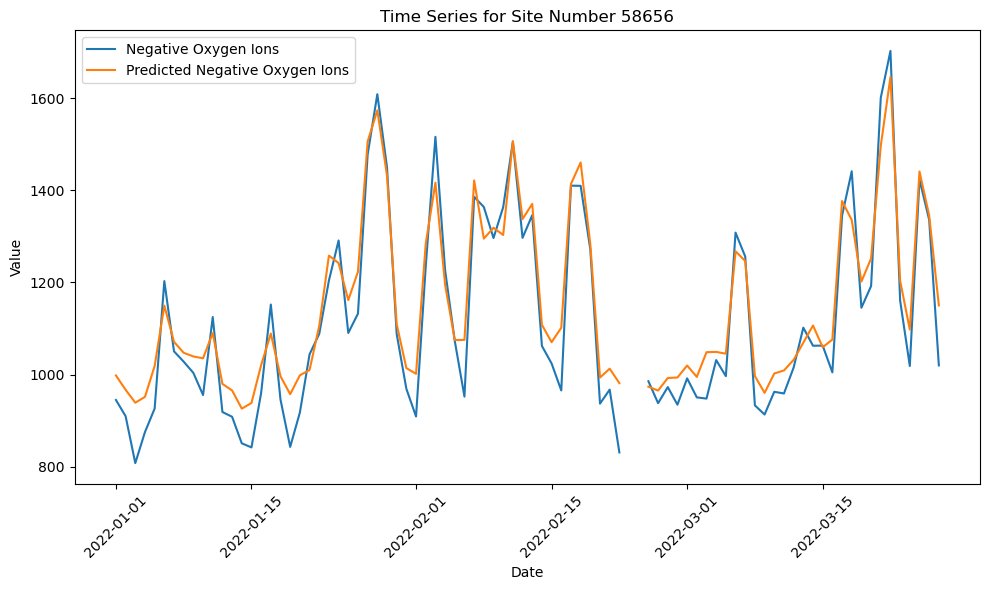

In [8]:
import matplotlib.pyplot as plt
# Aggregate to daily means
merged_df=df[["Site_number","time","Negative_oxygen_ions","longitude","latitude","predicted"]]
df_plot = merged_df.resample('D', on='time').mean()

# Plotting the time series for 'Negative_oxygen_ions' and 'predicted' columns
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Negative_oxygen_ions'], marker='', linestyle='-', label='Negative Oxygen Ions')
plt.plot(df_plot.index, df_plot['predicted'], marker='', linestyle='-', label='Predicted Negative Oxygen Ions')

plt.title(f'Time Series for Site Number {site_number}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Short Term Trend - Hourly Monitoring (and StD)

In [15]:
df_plot

,Hour,NOI_mean,NOI_std,Predicted_mean,Predicted_std
0,0,1125.865291,935.976903,1155.377616,737.855565
1,4,1135.273328,945.072146,1165.986666,722.475762
2,8,1084.460139,880.766912,1130.382103,681.692749
3,12,1126.879416,878.816452,1148.825253,694.399652
4,16,1174.083420,943.305703,1193.315036,740.849583
5,20,1088.954491,904.731372,1123.538112,695.695514


C:\Users\isxzl\AppData\Local\Temp\ipykernel_4680\2898581050.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Hour'] = merged_df['time'].dt.hour


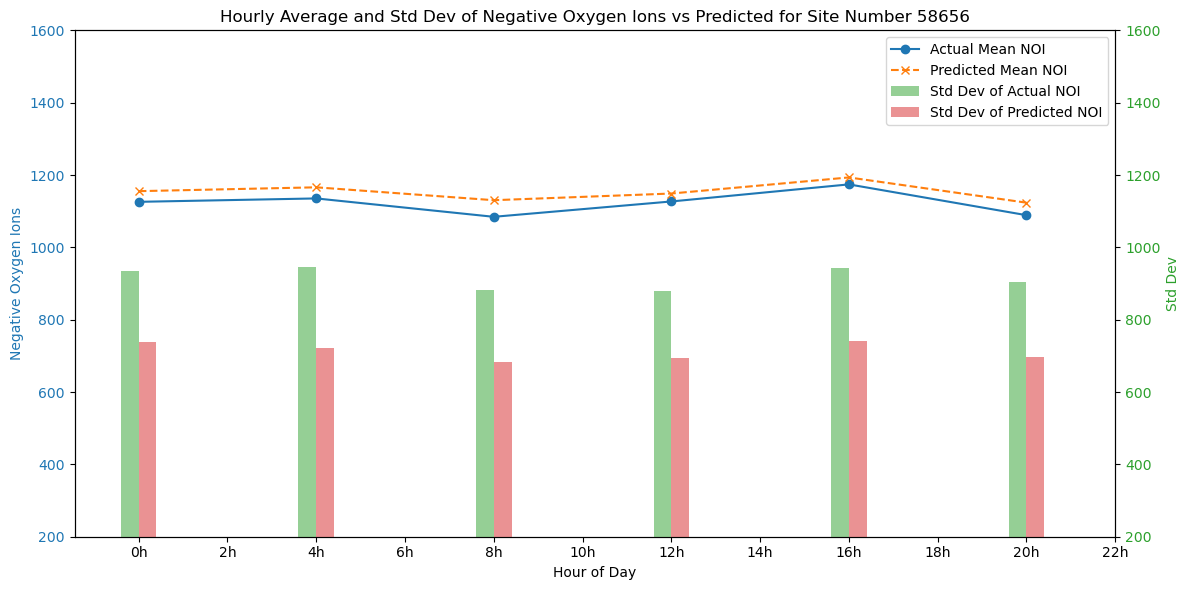

In [19]:
#merged_df=df[["Site_number","time","Negative_oxygen_ions","longitude","latitude","predicted"]]

#merged_df["predicted"] = merged_df["Negative_oxygen_ions"] + np.random.uniform(-400, 400, size=len(merged_df))
merged_df=df[["Site_number","time","Negative_oxygen_ions","longitude","latitude","predicted"]]

# Assuming 'merged_df' includes 'Datetime', 'Negative_oxygen_ions', 'predicted'
import pandas as pd
import matplotlib.pyplot as plt

# Example data setup (this part is just illustrative and won't be executed)
# merged_df = pd.DataFrame(...)

# Your provided code with modifications
merged_df['Hour'] = merged_df['time'].dt.hour
# Aggregate to hourly means and standard deviations for both actual and predicted
df_plot = merged_df.groupby('Hour').agg({'Negative_oxygen_ions': ['mean', 'std'], 
                                         'predicted': ['mean', 'std']}).reset_index()
df_plot.columns = ['Hour', 'NOI_mean', 'NOI_std', 'Predicted_mean', 'Predicted_std']  # Updated column names

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Actual NOI mean values
color_actual = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Negative Oxygen Ions', color=color_actual)
ax1.plot(df_plot['Hour'], df_plot['NOI_mean'], marker='o', linestyle='-', color=color_actual, label='Actual Mean NOI')
ax1.tick_params(axis='y', labelcolor=color_actual)

# Predicted NOI mean values
color_predicted = 'tab:orange'
ax1.plot(df_plot['Hour'], df_plot['Predicted_mean'], marker='x', linestyle='--', color=color_predicted, label='Predicted Mean NOI')

# Adjust y-axis for NOI
ax1.set_ylim(200, 1600)

# Adding a secondary y-axis for the standard deviation
ax2 = ax1.twinx()
color_std_actual = 'tab:green'
color_std_predicted = 'tab:red'
ax2.set_ylabel('Std Dev', color=color_std_actual)
# Plot for actual NOI standard deviation
ax2.bar(df_plot['Hour'] - 0.2, df_plot['NOI_std'], width=0.4, alpha=0.5, color=color_std_actual, label='Std Dev of Actual NOI')
# Plot for predicted NOI standard deviation
ax2.bar(df_plot['Hour'] + 0.2, df_plot['Predicted_std'], width=0.4, alpha=0.5, color=color_std_predicted, label='Std Dev of Predicted NOI')
ax2.tick_params(axis='y', labelcolor=color_std_actual)

# Correctly scale the Std Dev axis
std_max = max(df_plot['NOI_std'].max(), df_plot['Predicted_std'].max())
std_min = min(df_plot['NOI_std'].min(), df_plot['Predicted_std'].min())
ax2.set_ylim(std_min - (std_max - std_min) * 0.1, std_max + (std_max - std_min) * 0.1)
ax2.set_ylim(200, 1600)
plt.title(f'Hourly Average and Std Dev of Negative Oxygen Ions vs Predicted for Site Number {site_number}')
plt.xticks(ticks=range(0, 24, 2), labels=[f'{hour}h' for hour in range(0, 24, 2)])

# Enhance legend to include all elements
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

fig.tight_layout()
plt.show()


# LandUse, Differnet Land Use.

Given:
- predidcted df
- feature
- Xarray of Landuse
- Given date
Wanted:
- Plot Landuse
- Statistics of Landuse
- Box plot classified by landuse

In [20]:
grib_predicted=r"C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2022_Jan_2_Mar_predicted.nc"
date='2022-02-25T4:00:00.000000000'

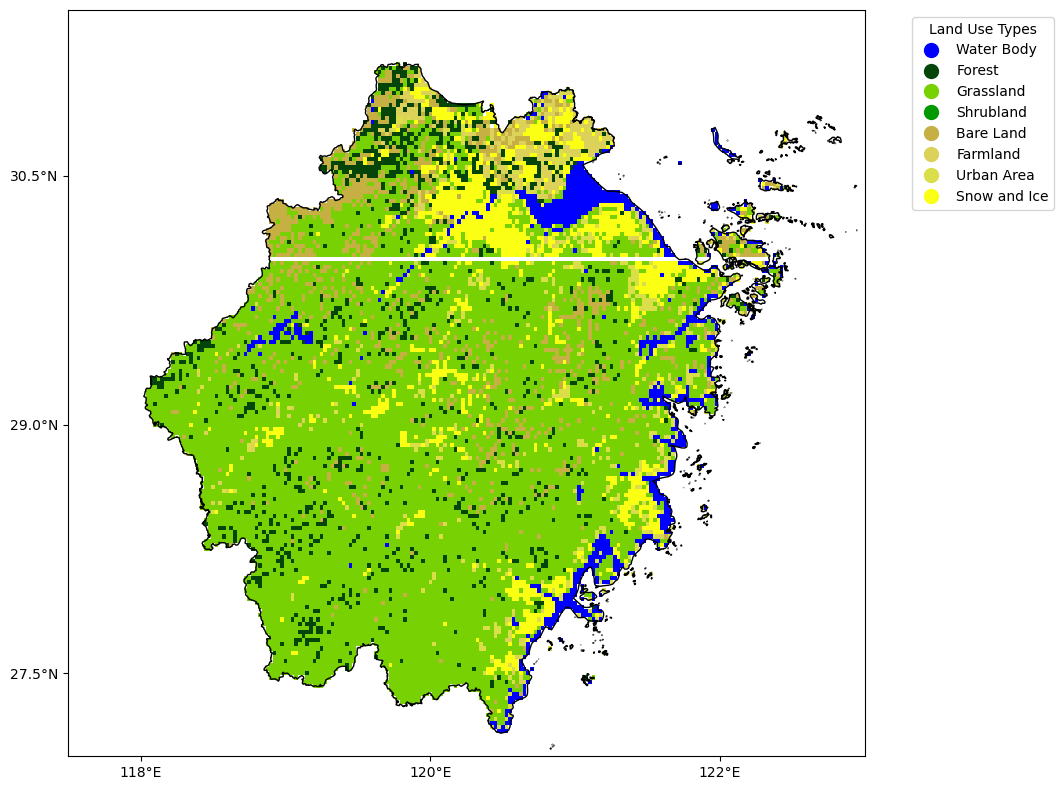

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.lines as mlines
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.prediction import make_mask, plot_single_ds
# Assuming 'grib_predicted' is defined and points to your dataset
# Assuming 'make_mask' is defined in your imported module and works as expected
# Assuming 'date' variable is defined and holds the desired date string

# Open the dataset and select data for the specified date
ds = xr.open_dataset(grib_predicted)
data_slice = ds.sel(time=date)['LC_Type4']

# Apply mask to focus on the Zhejiang area
zhejiang = gpd.read_file(r'C:\Datasets\Zhejiang20-23RS\Earth\Xian_dissolved.shp').to_crs('EPSG:4326')
mask = make_mask(data_slice, zhejiang)
data_slice = data_slice.where(mask)

# Prepare longitude and latitude meshgrid
longitude = ds.longitude.values
latitude = ds.latitude.values
lon, lat = np.meshgrid(longitude, latitude)

# Create a DataFrame for land use types and their colors
land_use_info = pd.DataFrame({
    'Value': [0, 1, 4, 5, 6, 7, 8, 9],
    'Color': ['blue', '#05450a', '#78d203', '#009900', '#c6b044', '#dcd159', '#dade48', '#fbff13'],
    'Legend Name': ['Water Body', 'Forest', 'Grassland', 'Shrubland', 'Bare Land', 'Farmland', 'Urban Area', 'Snow and Ice']
})

# Adjust the data slice for forest merging (if necessary)
# Assuming that 1, 2, 3 values in the original data_slice are for different forest types
# This step would require you to adjust the data_slice values accordingly if they are not already merged

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Use pcolormesh to plot the data slice with the color mapping
cmap = plt.matplotlib.colors.ListedColormap(land_use_info['Color'].tolist())
norm = plt.matplotlib.colors.BoundaryNorm(boundaries=np.arange(-0.5, len(land_use_info) + 0.5, 1), ncolors=len(land_use_info))

mesh = ax.pcolormesh(lon, lat, data_slice, cmap=cmap, norm=norm)

# Plot the shapefile as a boundary
zhejiang.plot(ax=ax, color='none', edgecolor='black')

# Customize the map with specified bounds and labels
ax.set_xlim([117.5, 123])
ax.set_ylim([27, 31.5])
xxrange = np.arange(118, 123, 2)
yyrange = np.arange(27.5, 31.5, 1.5)
ax.set_xticks(xxrange)
ax.set_yticks(yyrange)
ax.set_xticklabels([f"{x}°E" for x in xxrange])
ax.set_yticklabels([f"{y}°N" for y in yyrange])
ax.axis('on')

# Add custom legends using Line2D
legend_handles = [mlines.Line2D([], [], color=row['Color'], marker='o', linestyle='None', markersize=10, label=row['Legend Name']) for index, row in land_use_info.iterrows()]
ax.legend(handles=legend_handles, title='Land Use Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


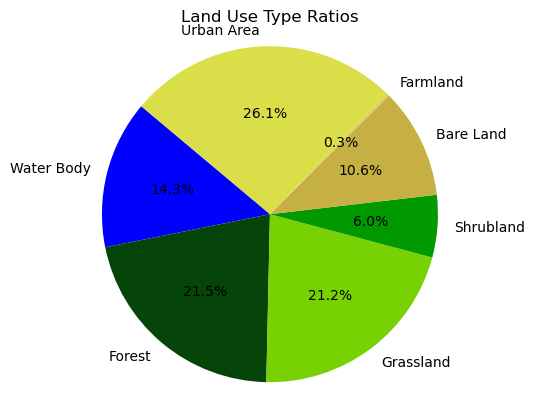

In [23]:
# Adjust the data slice for forest merging
merged_values = {2: 1, 3: 1}  # Merging different forest types into a single 'forest' category
data_slice_merged = xr.where(data_slice.isin(merged_values.keys()), 1, data_slice)

# Prepare data for the pie chart
values, counts = np.unique(data_slice_merged.values.flatten(), return_counts=True)
counts_dict = dict(zip(values, counts))

# Filter counts for the pie chart based on the simplified legend
pie_labels = [row['Legend Name'] for index, row in land_use_info.iterrows() if row['Value'] in counts_dict]
pie_colors = [row['Color'] for index, row in land_use_info.iterrows() if row['Value'] in counts_dict]
pie_sizes = [counts_dict.get(value, 0) for value in land_use_info['Value']]

# Removing zeros and corresponding labels and colors for the pie chart
pie_labels = [label for size, label in zip(pie_sizes, pie_labels) if size > 0]
pie_colors = [color for size, color in zip(pie_sizes, pie_colors) if size > 0]
pie_sizes = [size for size in pie_sizes if size > 0]

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(pie_sizes, labels=pie_labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Land Use Type Ratios')
plt.show()


In [24]:
merged_df["predicted"] = merged_df["Negative_oxygen_ions"] + np.random.uniform(-400, 400, size=len(merged_df))
merged_df=df[["Site_number","time","Negative_oxygen_ions","longitude","latitude","predicted"]]

C:\Users\isxzl\AppData\Local\Temp\ipykernel_4680\960556954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["predicted"] = merged_df["Negative_oxygen_ions"] + np.random.uniform(-400, 400, size=len(merged_df))


merged_df

given 
df has column Site_number	time(pd timestamp format)	Negative_oxygen_ions	longitude	latitude	 others etc,.
ds:the landuse for given time data_slice, has time, longitude, latitude dimnesions
fea=Negative_oxygen_ions: column to aggregate.
Wanted:
Box plot


In [ ]:
grib_predicted=r"C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2022_Jan_2_Mar_predicted.nc"
date='2022-02-25T4:00:00.000000000'
site_Feature_clean_pkl= r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\site_withCoor_withFea_cleaned.pkl'

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 67.92it/s]


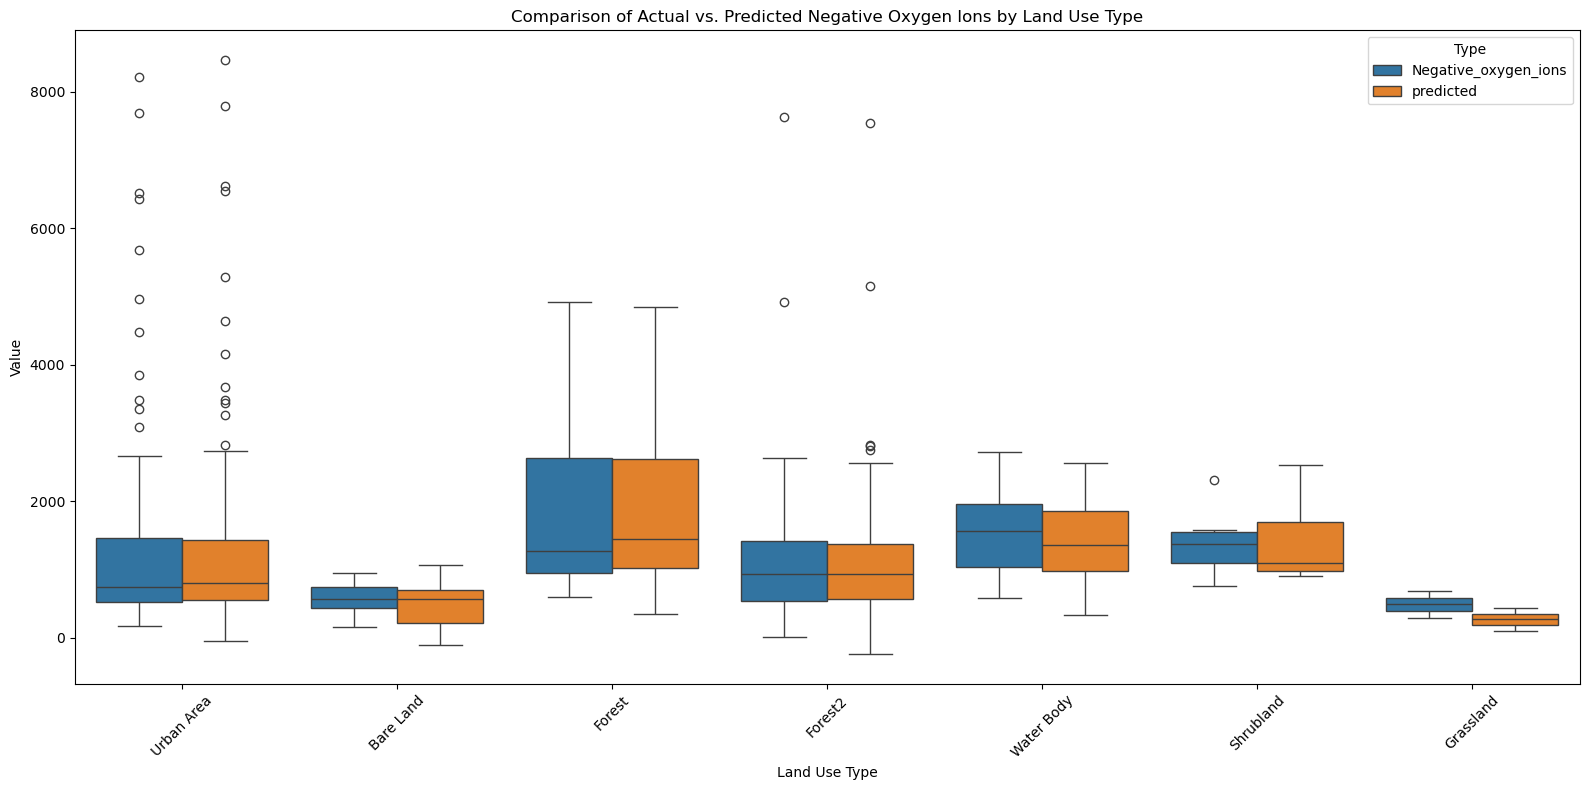

In [26]:

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from tqdm import tqdm
import numpy as np

tqdm.pandas()
# Assuming grib_predicted, date, and csv_pkl paths are correctly defined
# Load the dataset and extract the specific data slice
ds = xr.open_dataset(grib_predicted)
data_slice = ds.sel(time=date)['LC_Type4']

# Load the DataFrame
df = pd.read_pickle(site_Feature_clean_pkl).sample(300)  # Sampled for performance
df["predicted"] = df["Negative_oxygen_ions"] + np.random.uniform(-400, 400, size=len(df))

# Function to find the nearest index in the array for a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Add land use type to the DataFrame based on coordinates
df['land_use_type'] = df.progress_apply(
    lambda row: data_slice.sel(
        longitude=data_slice.longitude[find_nearest(data_slice.longitude, row['longitude'])], 
        latitude=data_slice.latitude[find_nearest(data_slice.latitude, row['latitude'])]
    ).values.item(0), 
    axis=1
)


# Group by land use type and prepare for plotting
grouped = df.groupby('land_use_type')['Negative_oxygen_ions']


import seaborn as sns
# Define land use information
land_use_info = pd.DataFrame({
    'Value': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Legend Name': ['Water Body', 'Forest', 'Forest2', 'Forest3', 'Grassland', 'Shrubland', 'Bare Land', 'Farmland', 'Urban Area', 'Snow and Ice']
})

# Melt the DataFrame to long format for seaborn plotting
df_melted = df.melt(id_vars=['land_use_type'], value_vars=['Negative_oxygen_ions', 'predicted'], 
                    var_name='Type', value_name='Value')

# Map land use type codes to legend names for readable labels
df_melted['land_use_type'] = df_melted['land_use_type'].map(land_use_info.set_index('Value')['Legend Name'])

# Plot using seaborn
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_melted, x='land_use_type', y='Value', hue='Type')

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.xlabel('Land Use Type')
plt.ylabel('Value')
plt.title('Comparison of Actual vs. Predicted Negative Oxygen Ions by Land Use Type')
plt.legend(title='Type')
plt.tight_layout()
plt.show()